## 1_tensor_tutorial

In [1]:
import torch
import numpy as np

In [2]:
#tensor 만들기

x=torch.empty(5,3) #그냥 uninitialize된 5X3 matrix tensor
x=torch.rand(5,3) #randomly initialized
x=torch.randn(5,3) #randomly initialized
x=torch.zeros(5,3,dtype=torch.long)
x=torch.ones(5,3,dtype=torch.long)
x=torch.tensor([5.5,3]) #정해진 데이터로 tensor만들기

x = x.new_ones(5, 3, dtype=torch.double) #기존에 존재하던 tensor를 바꿈. 숫자는 1
x = torch.randn_like(x, dtype=torch.float) #size는 유지하고 숫자만 random 생성

<div class="alert alert-info"><h4>Note</h4><p>Any operation that mutates a tensor in-place is post-fixed with an ``_``.
    For example: ``x.copy_(y)``, ``x.t_()``, will change ``x``.</p></div>

You can use standard NumPy-like indexing with all bells and whistles!

In [3]:
#tensor더하기 : x+y, torch.add(x,y), y.add_(x), y.add(x)

x = torch.rand(5, 3)
y = torch.rand(5, 3)

#더하는 방법
x+y 
torch.add(x,y)
y.add(x) #add : y자체는 안바뀜
y.add_(x) #add_ : y자체도 바뀜

tensor([[0.9227, 0.6221, 1.4474],
        [1.2287, 1.0236, 1.1667],
        [1.3167, 1.3271, 1.1000],
        [1.1492, 1.5279, 1.5294],
        [1.5372, 1.5618, 1.0411]])

In [34]:
x = torch.randn(4, 4)

#tensor 크기
x.size() #torch.Size([5, 3])

#tensor 크기 재구성하기
y = x.view(16)
z = x.view(-1, 8)  # the size -1 is inferred from other dimensions
print(x.size(), y.size(), z.size())

#x.item(): python number로 바꿔줌
x = torch.rand(1)
print(x)
print(x.item())

torch.Size([4, 4]) torch.Size([16]) torch.Size([2, 8])
tensor([0.7652])
0.765160083770752


In [44]:
# tensor->np = .numpy()
# np->tensor = torch.from_numpy(np)

a = torch.ones(5) #tensor([1., 1., 1., 1., 1.])

a.add_(1) #tensor.add_(숫자)

a = a.numpy() #tensor.numpy() = np.array

a = torch.from_numpy(a) #torch.from_numpy(np) = torch.tensor

## 2_autograd_tutorial

Autograd: 미분자동화
===================================

Central to all neural networks in PyTorch is the ``autograd`` package.
Let’s first briefly visit this, and we will then go to training our
first neural network.

Pytorch의 모든 신경망에서 중심이 되는것은 ``autograd``패키지 입니당. ``autograd``패키지는 tensor의 모든 수식에 대해 자동 미분을 제공합니다. 


Tensor
--------

``torch.Tensor`` : 패키지의 중심이 되는 클래스 

``.requires_grad``: tensor의 attribute로서, ``True``로 설정한 경우 모든 수식에 대해 추적하기 시작합니다. 

``.backward()``: 계산을 모두 끝낸 후에는 이것을 호출합니다. 그러면 모든 gradient가 자동으로 계산됩니다. 

``.grad``: tensor에 대한 gradient는 여기에 축적될겁니다.

``.detach()``:를 하면 tensor가 history를 거슬러 올라가는것을 멈춥니다.

``with torch.no_grad():`` 코드 블록을 감싸면, tracking history and using memory를 멈춥니다. 이는 모델을 평가할때 도움이 되는데요, ``requires_grad=True``인 train 가능한 parameter가 있음에도, 이것의 gradient가 필요하지 않은 경우 유용합니다. 

``Function``: 미분 자동화에 매우 중요한 클래스. ``Tensor``와 연결되어 acyclic graph를 만들어낸다. 

``.grad_fn`` attribute that references a ``Function`` that has created the ``Tensor`` (except for Tensors created by the user - their ``grad_fn is None``).

In [ ]:
x = torch.ones(2, 2, requires_grad=True)
y = x + 2
y.grad_fn#<AddBackward0 at 0x7f0b23b94470>
z = y * y * 3 #tensor([[27., 27.],[27., 27.]], grad_fn=<MulBackward0>)
out = z.mean() #tensor(27., grad_fn=<MeanBackward0>)

In [51]:
print(x.grad) #None
out.backward()
print(x.grad) #tensor([[4.5000, 4.5000], [4.5000, 4.5000]])

None
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


In [55]:
## 뒷부분은 잘 모르겠음..

## 4_neural_networks_tutorial

forward함수를 정의하면, backward 함수는 autograd를 사용함으로써 자동으로 정의할 수 있다. 

forward함수 내부에서는 tensor 수식 아무거나 써도 된다. 

학습 가능한 모든 parameter는 net.parameter()가 리턴해준다

<div class="alert alert-info"><h4>Note</h4><p>


**Recap:**
  -  ``torch.Tensor`` - A *multi-dimensional array* with support for autograd
     operations like ``backward()``. Also *holds the gradient* w.r.t. the
     tensor.
  -  ``nn.Module`` - Neural network module. *Convenient way of
     encapsulating parameters*, with helpers for moving them to GPU,
     exporting, loading, etc.
  -  ``nn.Parameter`` - A kind of Tensor, that is *automatically
     registered as a parameter when assigned as an attribute to a*
     ``Module``.
  -  ``autograd.Function`` - Implements *forward and backward definitions
     of an autograd operation*. Every ``Tensor`` operation creates at
     least a single ``Function`` node that connects to functions that
     created a ``Tensor`` and *encodes its history*.


In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

params = list(net.parameters())
# print(len(params)) 10
# print(params[0].size())  torch.Size([6, 1, 3, 3])

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [32]:
#인풋을 정의하고
input = torch.randn(1, 1, 32, 32)

#input을 네트워크에 넣음. 
out = net(input)
# print(out) tensor([[ 0.0422,  0.0836, -0.0476, -0.0186, -0.0252,  0.0487, -0.0157, -0.1110,
#           0.0900, -0.0701]], grad_fn=<AddmmBackward>)

#그래디언트를 모두 zero로 만듬
net.zero_grad() 

#backword를 함.
out.backward(torch.randn(1, 10))

In [38]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.9203, grad_fn=<MseLossBackward>)


In [31]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

In [39]:
## backprop 

net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([ 0.0118,  0.0020,  0.0049,  0.0007, -0.0041,  0.0019])


In [40]:
## update the weights

import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

## 3_cifar10_tutorial

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

100%|█████████▉| 170065920/170498071 [00:20<00:00, 4375310.44it/s]

Files already downloaded and verified


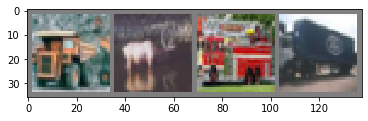

truck  deer truck truck


In [17]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [19]:
#2. CNN 네트워크 정의하기. 
#3. Loss function과 optimizer 정의하기. 이때 cross-entropy loss와 sgd를 사용하기로 했음

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net() #->net(inputs)를 돌림. 
criterion = nn.CrossEntropyLoss() #-> criterion(outputs,labels)를 돌림 -> loss.backward()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #->optimizer.zero_grad() ->optimizer.step()

In [20]:
#4. 네트워크 학습하기. 

#epoch이 2개 : 1 epoch은 전체 데이터 순회 1번을 의미함


for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')



[1,  2000] loss: 2.200
[1,  4000] loss: 1.855
[1,  6000] loss: 1.682
[1,  8000] loss: 1.570
[1, 10000] loss: 1.512
[1, 12000] loss: 1.457
[2,  2000] loss: 1.378
[2,  4000] loss: 1.354
[2,  6000] loss: 1.341
[2,  8000] loss: 1.318
[2, 10000] loss: 1.309
[2, 12000] loss: 1.286
Finished Training


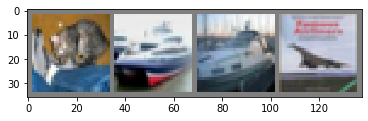

GroundTruth:    cat  ship  ship plane


In [22]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [23]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car  ship  ship


In [24]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


In [25]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 44 %
Accuracy of   car : 68 %
Accuracy of  bird : 45 %
Accuracy of   cat : 36 %
Accuracy of  deer : 46 %
Accuracy of   dog : 28 %
Accuracy of  frog : 76 %
Accuracy of horse : 48 %
Accuracy of  ship : 85 %
Accuracy of truck : 52 %
